In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import requests
from PIL import Image
import numpy as np
import warnings
import sys

# Adiciona o diretório 'src' ao path para que possamos importar seus módulos
# (Se o notebook estiver na raiz do projeto, isso funciona)
sys.path.append('src')

# --- Importa a SUA função de carregar o InternVL ---
from src.models.lvlm_handler import load_model, warm_up_model, prepare_inputs_for_multimodal_embedding
from src.data_loaders.documentpairs import DocumentPairDataset 
from src.models.siamese_internVL import build_siamese_internvl
# (Vou precisar das funções 'load_image' e 'prepare_inputs_...' 
# que são chamadas dentro do seu código. Vou assumir que elas 
# estão em 'src.data_loaders.documentpairs' ou similar)

# Vamos precisar ADICIONAR estas importações que seu script usa internamente:
from src.utils.image_processing import load_image, find_closest_aspect_ratio, build_transform, dynamic_preprocess

# --- Imports padrão para carregar o Qwen-VL ---
# (Não podemos usar sua função aqui, pois ela é específica para o InternVL)
from transformers import AutoModelForCausalLM, AutoTokenizer as AutoTokenizerQwen

# --- Imports padrão para o InternVL (se necessário) ---
from transformers import AutoModel, AutoTokenizer as AutoTokenizerIntern
from tqdm import tqdm
warnings.filterwarnings("ignore")
print("Bibliotecas e módulos importados.")

Bibliotecas e módulos importados.


In [2]:
# --- 2. Carregar seu modelo InternVL ---
# Use o model_name ou checkpoint_path que você usa no seu script 'run_evaluation.py'
MODEL_NAME = "InternVL3-2B" # Ou 'InternVL3-2B', etc.
CHECKPOINT_PATH = None # Ou o caminho para seu 'student_head'

print(f"Carregando {MODEL_NAME} com sua função 'load_model'...")
# Nota: Assumindo que seu 'load_model' lida com PeftModel, etc.
# Se você estiver usando um 'student_head', ele será carregado aqui.
model, processor, tokenizer, connector, head = load_model(
    model_name=MODEL_NAME,
    adapter_path=CHECKPOINT_PATH,
    load_in_4bit=False, # Use False (8-bit) ou 4-bit, como preferir
    projection_output_dim=512 
)

Carregando InternVL3-2B com sua função 'load_model'...
--- 1. Carregando o Modelo Base: OpenGVLab/InternVL3-2B ---
    -> Configurando para carregar em bfloat16 (precisão total).
✅ Processador e Tokenizer carregados.
✅ Carregamento concluído.


In [5]:
import re
from collections import OrderedDict, defaultdict

# helpers
def fmt(n): return f"{n:,}"
def pct(n, total): return 100.0 * n / total if total else 0.0

# total params for percentages
total_params = sum(p.numel() for p in model.parameters())

# get named modules in original order
named = list(model.named_modules())

# compute direct params for each named module (recurse=False)
direct = OrderedDict()
for name, mod in named:
    s = 0
    for p in mod.parameters(recurse=False):
        s += p.numel()
    direct[name] = s

# normalize function: collapse ".layers.<num>" into ".layers.*"
layers_num_re = re.compile(r"\.layers\.\d+")
def normalize_subname(subname):
    return layers_num_re.sub(".layers.*", subname)

# We will preserve the order of first occurrence:
# groups_order: OrderedDict top -> OrderedDict(subnorm -> {"count", "params", "first_name"})
groups = OrderedDict()

for full_name, _ in named:
    # determine top-level token and the rest (sub)
    if full_name == "":
        top = "<root>"
        sub = ""
    else:
        parts = full_name.split(".", 1)
        top = parts[0]
        sub = parts[1] if len(parts) > 1 else ""
    # normalize the sub to collapse layer indices
    subnorm = normalize_subname(sub)
    # initialize structures preserving order of first seen top and subnorm
    if top not in groups:
        groups[top] = OrderedDict()
    if subnorm not in groups[top]:
        groups[top][subnorm] = {"count": 0, "params": 0, "first_name": full_name}
    # accumulate direct params for this exact full_name (may be zero)
    groups[top][subnorm]["count"] += 1
    groups[top][subnorm]["params"] += direct[full_name]

# Printing in model order: tops in order of first appearance; subs in order of first appearance
print(f"TOTAL PARAMETERS (model): {fmt(total_params)}\n")

for top, subdict in groups.items():
    if top == "<root>":  # skip root unless you want it
        continue
    # total for this top (sum of direct submodules)
    top_total = sum(info["params"] for info in subdict.values())
    print(f"## {top}")
    print(f"Total (sum of direct submodules): {fmt(top_total)} — {pct(top_total, total_params):.2f}%")
    for subnorm, info in subdict.items():
        # build display name: top + '.' + subnorm (or only top if subnorm empty)
        display_name = f"{top}.{subnorm}" if subnorm else top
        # if it's a collapsed layers entry, show aggregated count
        if ".layers.*" in subnorm:
            # try to indicate if it refers to .mlp specifically by checking first_name
            suffix_label = ".layers.*"
            # show how many original entries were collapsed (info['count'])
            print(f"- {display_name:70s}: {fmt(info['params'])} — {pct(info['params'], total_params):.2f}%  (count={info['count']})")
        else:
            print(f"- {display_name:70s}: {fmt(info['params'])} — {pct(info['params'], total_params):.2f}%  (count={info['count']})")
    print()  # blank line after each top-level class

# final counted check
counted = sum(info["params"] for g in groups.values() for info in g.values())
print("=== SUMMARY ===")
print(f"counted_by_direct_modules : {fmt(counted)} params ({pct(counted, total_params):.2f}%)")
print(f"TOTAL PARAMETERS (model)  : {fmt(total_params)} params")

TOTAL PARAMETERS (model): 2,088,957,440

## vision_model
Total (sum of direct submodules): 304,012,288 — 14.55%
- vision_model                                                          : 0 — 0.00%  (count=1)
- vision_model.embeddings                                               : 1,050,624 — 0.05%  (count=1)
- vision_model.embeddings.patch_embedding                               : 603,136 — 0.03%  (count=1)
- vision_model.encoder                                                  : 0 — 0.00%  (count=1)
- vision_model.encoder.layers                                           : 0 — 0.00%  (count=1)
- vision_model.encoder.layers.*                                         : 49,152 — 0.00%  (count=24)
- vision_model.encoder.layers.*.attn                                    : 0 — 0.00%  (count=24)
- vision_model.encoder.layers.*.attn.qkv                                : 75,571,200 — 3.62%  (count=24)
- vision_model.encoder.layers.*.attn.attn_drop                          : 0 — 0.00%  (count=24)
-

In [6]:
# --- Imagem Fixa ---
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
dir =  '../../../once-learning/separacao-rvl_cdip/microbiological_associates_invoice/87104266.tif'
image_pil_object = Image.open(dir).convert("RGB")
# image_pil_object = Image.open('ChatGPT Image 13 de nov. de 2025, 02_03_36.png').convert("RGB")
# --- CORREÇÃO AQUI ---
# Salvamos a imagem em um arquivo temporário
temp_image_path = "temp_visualization_image.jpg"

pixel_values = load_image(dir, max_num=12).to(model.device)
num_patches_list = [pixel_values.size(0)]

(-0.5, 771.5, 999.5, -0.5)

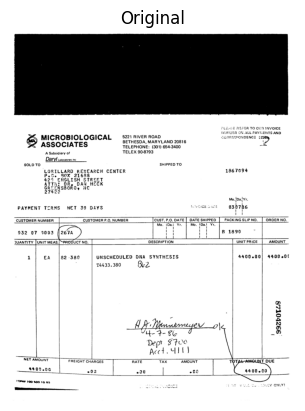

In [7]:
from PIL import Image
import matplotlib.pyplot as plt

plt.imshow(image_pil_object)
plt.title("Original")
plt.axis("off")


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch


IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

Número de splits: 13
pixel_values shape: torch.Size([13, 3, 448, 448])


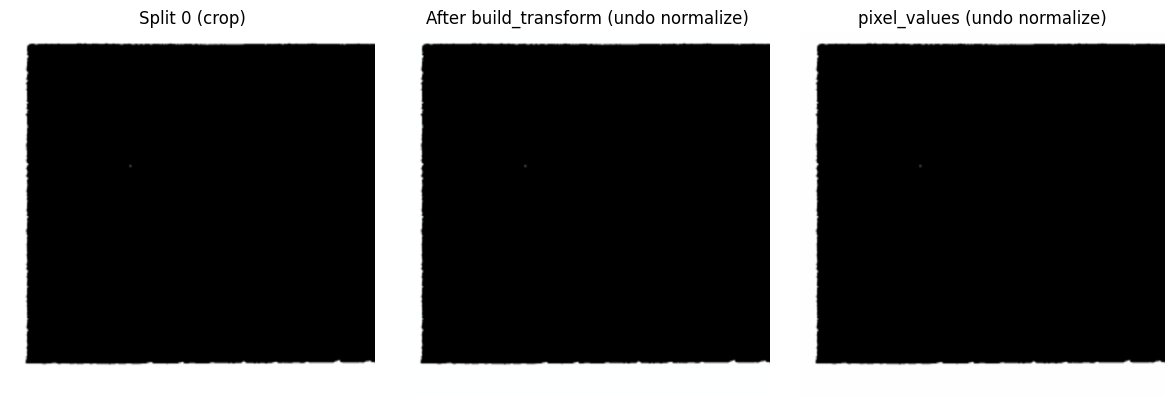

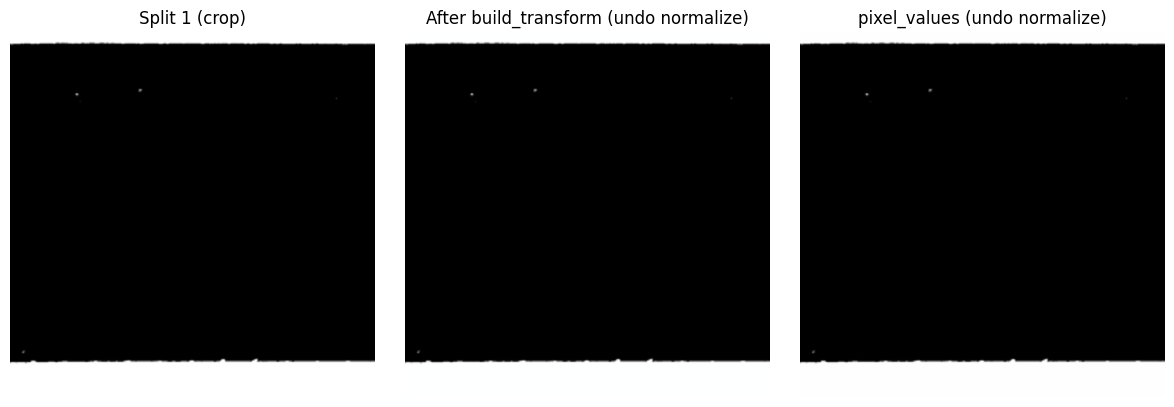

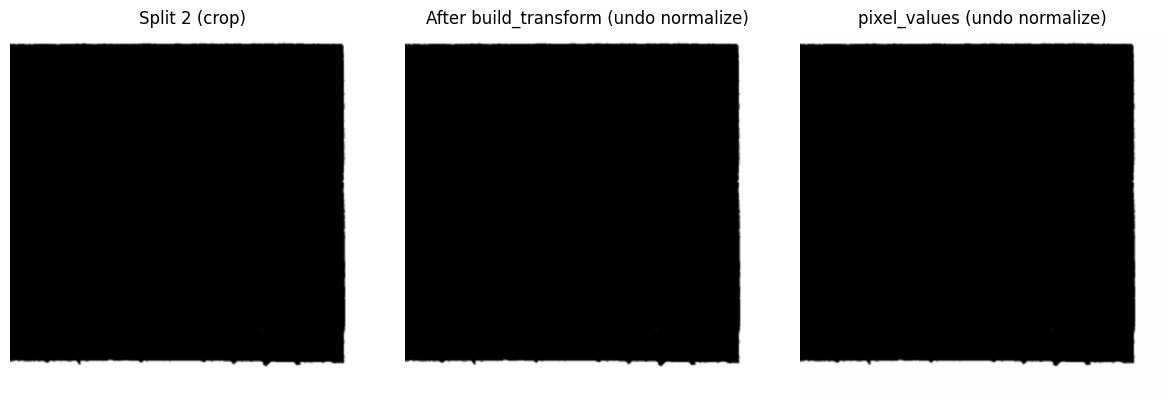

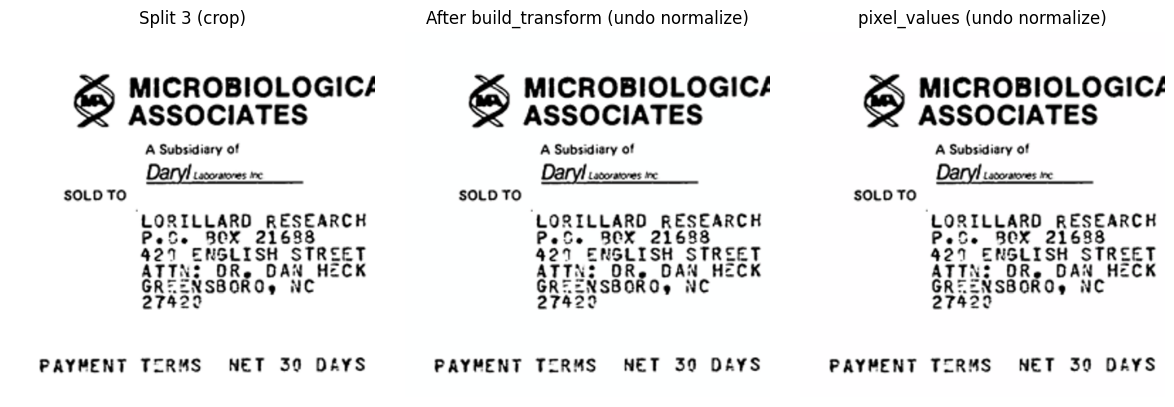

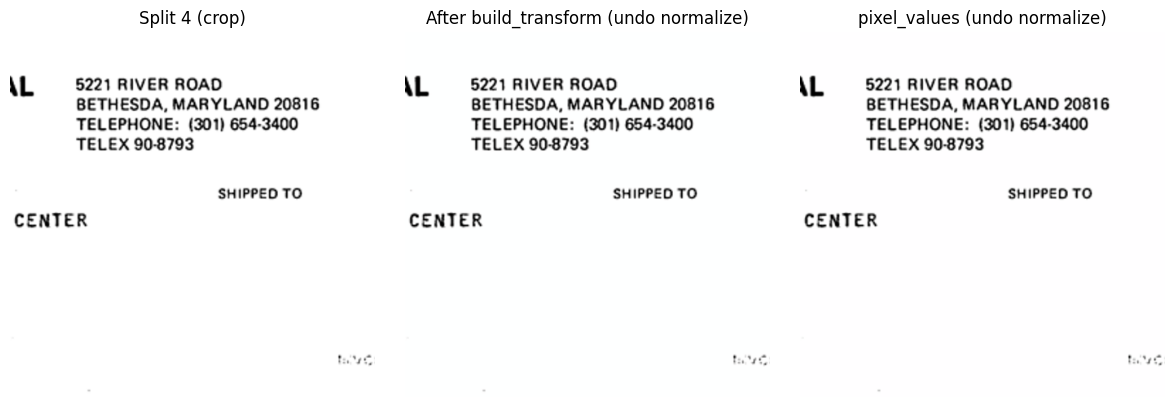

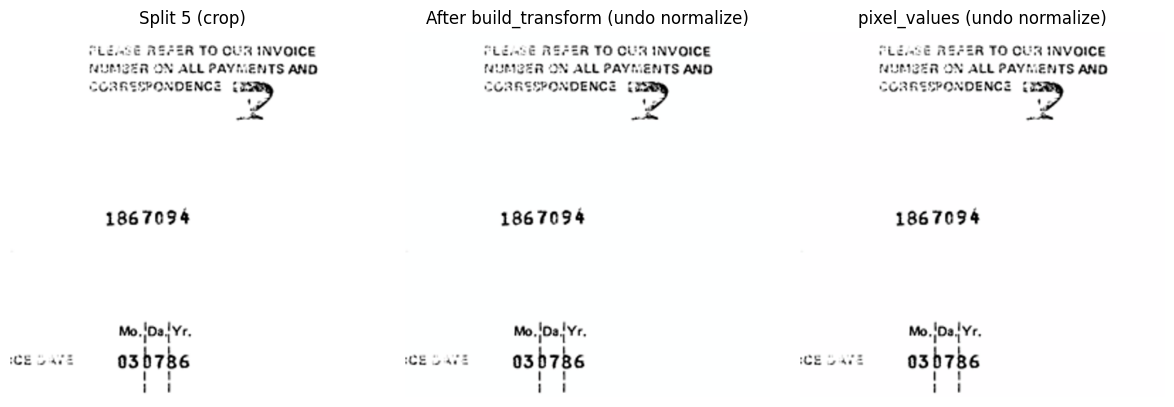

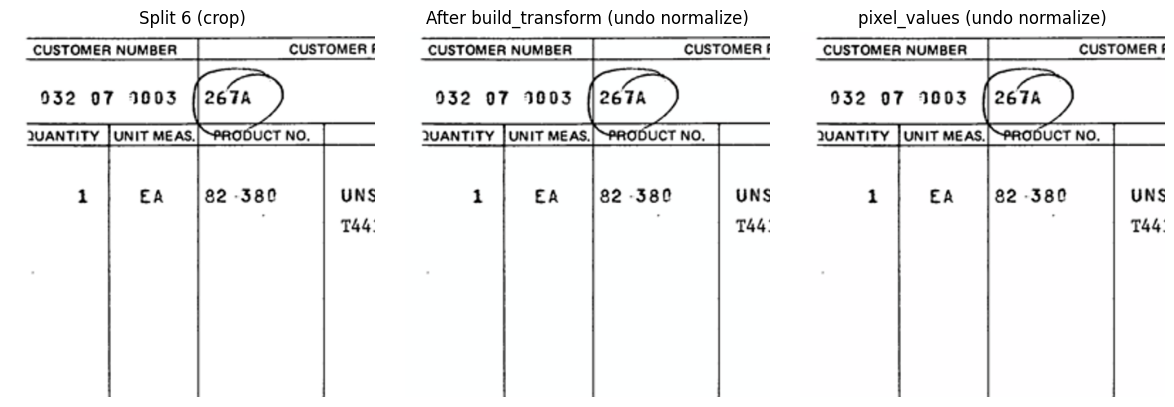

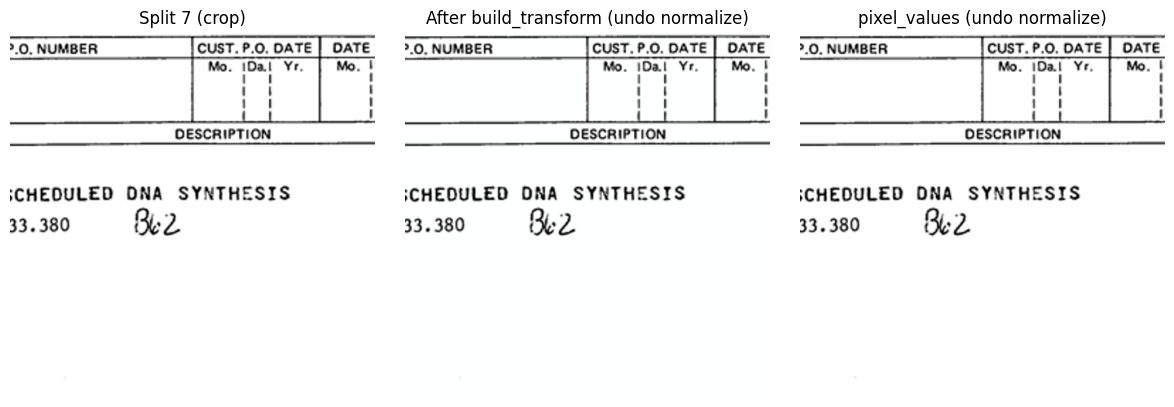

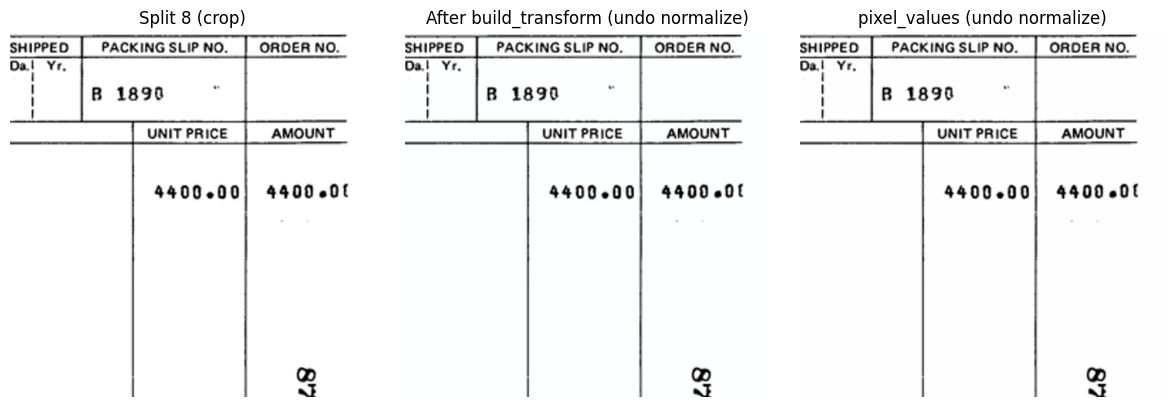

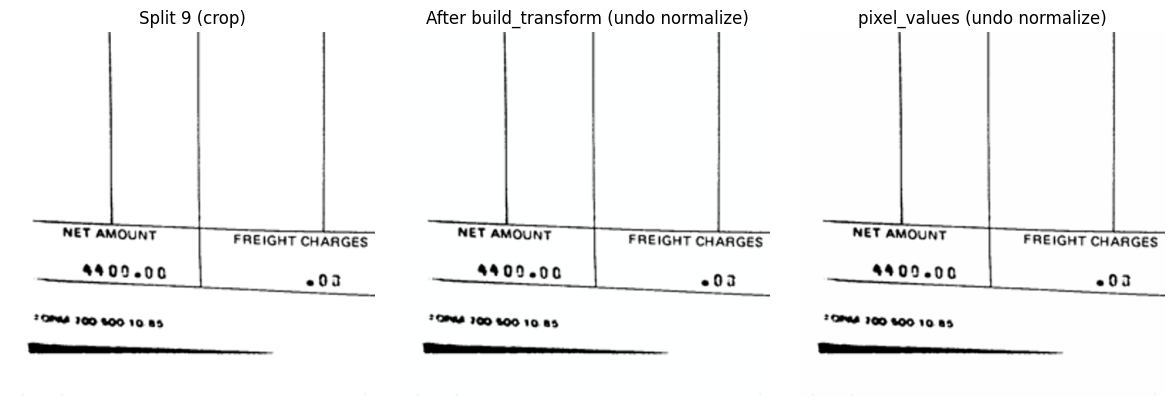

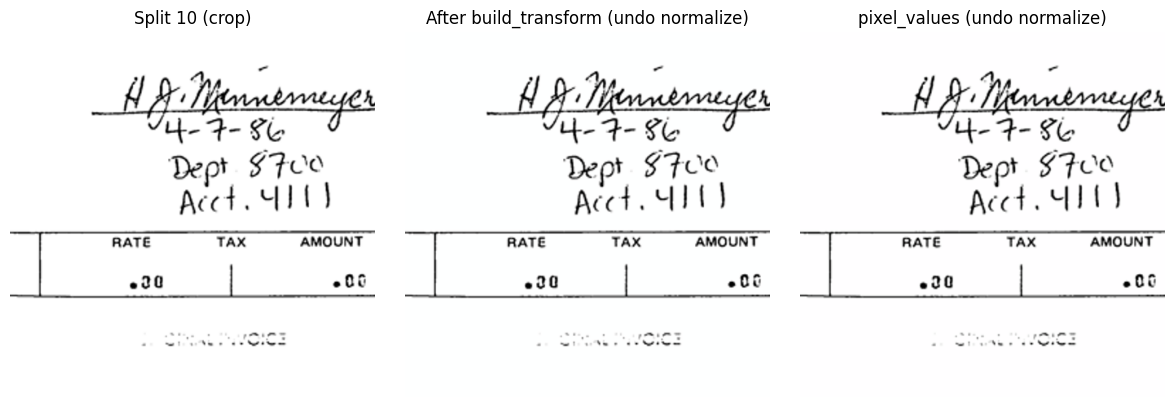

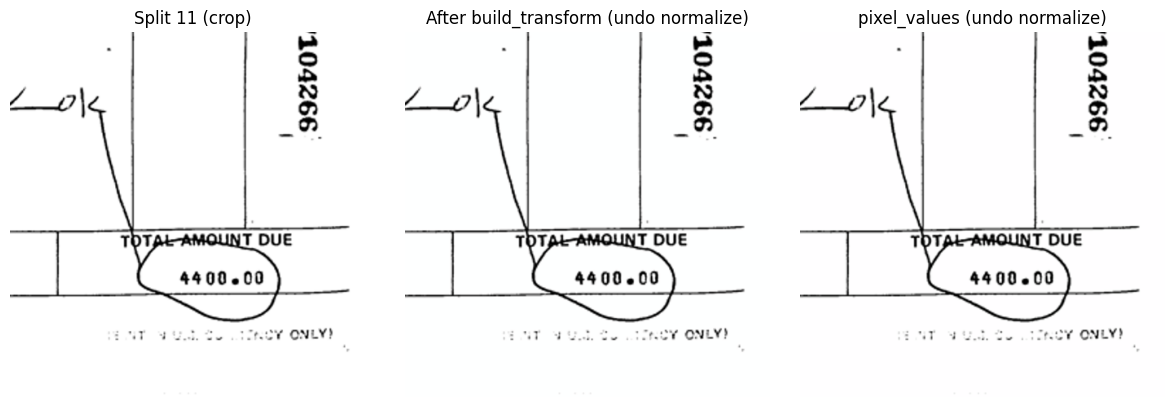

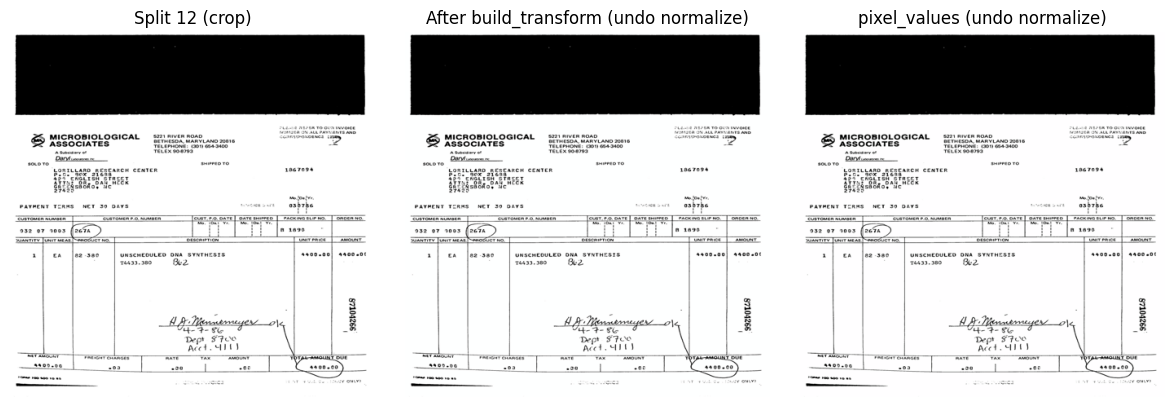


--- Métricas e mapas de diferença: último split (index 12) ---
orig stats:    mean=0.753873, std=0.407208, min=0.000000, max=1.000000
transform:     mean=0.753873, std=0.407208, min=0.000000, max=1.000000
pixel_values:  mean=0.753608, std=0.406880, min=0.000000, max=1.000000

RMSEs (orig vs ...):
 RMSE(orig, transform)    = 1.1281406722741218e-08
 RMSE(orig, pixel_values) = 0.0007844346180881351
 channel R: rmse(orig,trans)=7.245606e-09  rmse(orig,pv)=1.967822e-04
 channel G: rmse(orig,trans)=1.530535e-08  rmse(orig,pv)=1.323843e-03
 channel B: rmse(orig,trans)=9.749770e-09  rmse(orig,pv)=2.339444e-04


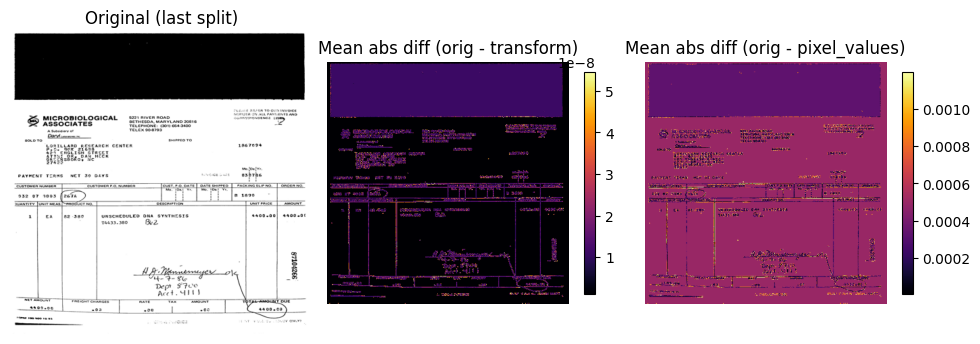

In [9]:
# Exibir ALL splits: para cada split mostrar (1) split cru, (2) após build_transform (undo normalize), (3) pixel_values correspondente (undo normalize).
# Além disso, calcular e mostrar métricas + mapas de diferença APENAS para o último split.
# Usa suas funções: dynamic_preprocess, build_transform, load_image (não define novas defs).

import numpy as np
import matplotlib.pyplot as plt
import torch

# constantes já presentes no ambiente
mean = np.array(IMAGENET_MEAN)
std  = np.array(IMAGENET_STD)

# --- 1) gerar splits, transform e pixel_values usando suas funções ---
# img deve ser um PIL.Image já carregado (se quiser, descomente e carregue aqui)
# from PIL import Image
# img = Image.open("sua_imagem.png").convert("RGB")

splits = dynamic_preprocess(image_pil_object, image_size=448, max_num=12, use_thumbnail=True)
print("Número de splits:", len(splits))

transform = build_transform(input_size=448)

# pixel_values retornado por load_image (pode ser bfloat16 e estar na GPU)
# pixel_values = load_image("sua_imagem.png", input_size=448, max_num=12, use_thumbnail=True)
print("pixel_values shape:", pixel_values.shape)

# helper inline: tensor CHW -> HWC [0,1] numpy (undo normalize)
def tensor_chw_to_vis_np(tensor_chw):
    t = tensor_chw.to(torch.float32).cpu()
    arr = t.permute(1,2,0).numpy()   # HWC, normalized
    vis = (arr * std + mean).clip(0,1)
    return vis

# --- 2) Mostrar cada split lado a lado (split | transform | pixel_values) ---
for i, split in enumerate(splits):
    # split PIL -> np [0,1]
    split_np = np.array(split).astype("float32") / 255.0

    # transform (ToTensor + Normalize) -> undo normalize para visualização
    trans_tensor = transform(split)            # CHW (torch)
    trans_vis = tensor_chw_to_vis_np(trans_tensor)

    # pixel_values: preferir o tensor retornado por load_image (se índice existir), fallback recomputando
    if i < pixel_values.shape[0]:
        pv_tensor = pixel_values[i]
    else:
        pv_tensor = transform(split).to(torch.bfloat16)
    pv_vis = tensor_chw_to_vis_np(pv_tensor)

    # plot 3 imagens lado a lado
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(split_np); plt.title(f"Split {i} (crop)"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(trans_vis); plt.title("After build_transform (undo normalize)"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(pv_vis); plt.title("pixel_values (undo normalize)"); plt.axis("off")
    plt.tight_layout()
    plt.show()

# --- 3) MÉTRICAS + mapas de diferença APENAS para o ÚLTIMO split ---
last_idx = len(splits) - 1
print("\n--- Métricas e mapas de diferença: último split (index {}) ---".format(last_idx))

# preparar arrays do último split
orig_np = np.array(splits[last_idx]).astype("float32") / 255.0
trans_tensor_last = transform(splits[last_idx])
trans_vis_last = tensor_chw_to_vis_np(trans_tensor_last)

if last_idx < pixel_values.shape[0]:
    pv_tensor_last = pixel_values[last_idx]
else:
    pv_tensor_last = transform(splits[last_idx]).to(torch.bfloat16)
pv_vis_last = tensor_chw_to_vis_np(pv_tensor_last)

# estatísticas resumidas
def rmse(a, b): return np.sqrt(((a - b)**2).mean())
def stats_str(x): return f"mean={x.mean():.6f}, std={x.std():.6f}, min={x.min():.6f}, max={x.max():.6f}"

print("orig stats:   ", stats_str(orig_np))
print("transform:    ", stats_str(trans_vis_last))
print("pixel_values: ", stats_str(pv_vis_last))
print("\nRMSEs (orig vs ...):")
print(" RMSE(orig, transform)    =", rmse(orig_np, trans_vis_last))
print(" RMSE(orig, pixel_values) =", rmse(orig_np, pv_vis_last))
for c, ch in enumerate(["R","G","B"]):
    print(f" channel {ch}: rmse(orig,trans)={rmse(orig_np[...,c], trans_vis_last[...,c]):.6e}  rmse(orig,pv)={rmse(orig_np[...,c], pv_vis_last[...,c]):.6e}")

# heatmaps de diferença média por pixel (média canais)
mean_abs_diff_t = np.mean(np.abs(orig_np - trans_vis_last), axis=2)
mean_abs_diff_pv = np.mean(np.abs(orig_np - pv_vis_last), axis=2)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.imshow(orig_np); plt.title("Original (last split)"); plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(mean_abs_diff_t, cmap="inferno"); plt.title("Mean abs diff (orig - transform)"); plt.axis("off"); plt.colorbar(shrink=0.6)
plt.subplot(1,3,3)
plt.imshow(mean_abs_diff_pv, cmap="inferno"); plt.title("Mean abs diff (orig - pixel_values)"); plt.axis("off"); plt.colorbar(shrink=0.6)
plt.tight_layout()
plt.show()


In [10]:
warm_up_model(model, processor)

Aquecendo o modelo com uma única imagem de teste...


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Saída de teste gerada (será descartada): 'A imagem é uma tela de vídeo com muitos'
Aquecimento do modelo concluído com sucesso.


In [11]:
def describe_image_simple(model, processor, tokenizer, image_path, prompt="Describe this image."):
    """
    Chamada oficial usando model.chat (necessária para InternVL3).
    """
    
    # carregar imagem
    pixel_values = load_image(image_path, max_num=12).to(model.device)

    # gerar resposta multimodal
    with torch.no_grad():
        answer = model.chat(
            tokenizer=tokenizer,
            pixel_values=pixel_values,
            question=prompt,
            generation_config=dict(
                max_new_tokens=200,
                do_sample=False,
                temperature=0.0,
            )
        )
    
    return answer

In [12]:
def prepare_inputs_for_multimodal_embedding(model, tokenizer, pixel_values, question, num_patches=None):
    device = model.device

    if '<image>' not in question:
        question = '<image>\n' + question

    if num_patches is None:
        num_patches = pixel_values.shape[0]  # número de blocos/imagens

    # Criar espaço de input para os vit_embeds
    image_tokens = '<img>' + ('<IMG_CONTEXT>' * model.num_image_token * num_patches) + '</img>'
    question = question.replace('<image>', image_tokens, 1)

    inputs = tokenizer(question, return_tensors='pt').to(device)
    return {
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask'],
        'pixel_values': pixel_values.to(device),
        'image_flags': torch.ones(pixel_values.shape[0], dtype=torch.long).to(device),
        'question': question
    }

In [13]:
import torch
from PIL import Image
import requests
from peft import PeftModel

def describe_image_simple(model, processor, tokenizer, image_path, prompt="Give me only the title of this document."):
    """
    Chamada CANÔNICA do InternVL3 (2B) para descrever uma imagem.
    Não altera nada do modelo, usa exatamente o forward padrão de geração.
    """

    # 1) Carrega e processa a imagem com sua função oficial
    pixel_values = load_image(image_path, max_num=12).to(model.device)

    # 2) Prepara inputs multimodais (sua função oficial)
    inputs = prepare_inputs_for_multimodal_embedding(model, tokenizer, pixel_values, prompt)

    # 3) Ajusta para PEFT se necessário
    inference_model = model.base_model if isinstance(model, PeftModel) else model
    model.eval()

    # 4) Geração de texto usando o modo nativo do InternVL
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=200,
            do_sample=False,
            top_p=1.0,
            # temperature=0.0,
            return_dict_in_generate=False
        )

    # 5) Decodificação final
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return response, inputs

In [15]:
model.config.pad_token_id = model.config.eos_token_id

descricao, inputs = describe_image_simple(model, processor, tokenizer, dir)
print(descricao)

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


 Microbiological Associates


In [16]:
print("Input IDs length:", len(inputs['input_ids'][0]))
print("Input question length:", len(inputs['question']))
print(inputs['question'])

Input IDs length: 3340
Input question length: 43316
<img><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CONTEXT><IMG_CO

In [17]:
ids = inputs['input_ids'].flatten().cpu().numpy()
img_id = model.img_context_token_id
positions = np.where(ids == img_id)[0]
print("image token positions:", positions[:50], "... total:", len(positions))

image token positions: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50] ... total: 3328


In [18]:
# 1) conferir input_ids e se img_context_token_id está presente
ids = inputs['input_ids'].flatten().cpu().numpy()
print("input_ids len:", ids.shape[0])
print("first 50 ids:", ids[:50])

# 2) id esperado pelo modelo (se disponível) e se está na sequência
print("model.img_context_token_id:", getattr(model, "img_context_token_id", None))
if getattr(model, "img_context_token_id", None) is not None:
    print("img_context_token_id in input_ids?:", int(getattr(model, "img_context_token_id") in ids))

# 3) verificar correspondência num_patches vs pixel_values
print("num_patches (inferred):", num_patches_list, "pixel_values.shape[0]:", pixel_values.shape[0])

input_ids len: 3340
first 50 ids: [151665 151667 151667 151667 151667 151667 151667 151667 151667 151667
 151667 151667 151667 151667 151667 151667 151667 151667 151667 151667
 151667 151667 151667 151667 151667 151667 151667 151667 151667 151667
 151667 151667 151667 151667 151667 151667 151667 151667 151667 151667
 151667 151667 151667 151667 151667 151667 151667 151667 151667 151667]
model.img_context_token_id: 151667
img_context_token_id in input_ids?: 1
num_patches (inferred): [13] pixel_values.shape[0]: 13


In [19]:
len(inputs['input_ids'][0])

3340

In [20]:
import numpy as np, torch

def test_projection_candidate(candidate_name):
    # encontra o módulo
    module = None
    for n, m in model.named_modules():
        if n == candidate_name:
            module = m
            break
    if module is None:
        raise RuntimeError(f"Module named '{candidate_name}' not found. Check spelling from the printed list.")

    print("Testing module:", candidate_name)
    W = getattr(module, "weight", None)
    bias = getattr(module, "bias", None)
    print(" weight attr exists:", isinstance(W, torch.Tensor))
    if isinstance(W, torch.Tensor):
        print(" weight shape:", tuple(W.detach().cpu().shape))
    if isinstance(bias, torch.Tensor):
        print(" bias shape:", tuple(bias.detach().cpu().shape))

    # preparar v_pooled (do workspace) e garantir device/dtype
    # v_pooled já existe no workspace (extraído anteriormente); se não existir, erro claro
    try:
        v = v_pooled  # torch tensor on CPU with float32 from earlier steps
    except NameError:
        raise RuntimeError("v_pooled não encontrado no workspace. Execute o trecho que extrai vit_embeds e pool antes.")

    print("v_pooled shape (used):", tuple(v.shape), "dtype:", v.dtype)

    direct_ok = False
    projected = None
    score = None

    # 1) tentar forward do módulo convertendo v para o dtype do módulo (evita mismatch)
    try:
        module_device = next(module.parameters()).device if any(True for _ in module.parameters()) else model.device
    except Exception:
        module_device = model.device

    try:
        # descobrir dtype que o módulo usa (p.ex. bfloat16)
        mod_dtype = None
        for p in module.parameters():
            mod_dtype = p.dtype
            break
        if mod_dtype is None:
            mod_dtype = torch.float32
        # mover v para dispositivo do módulo e converter dtype
        v_for_forward = v.to(device=module_device, dtype=mod_dtype)
        out = module(v_for_forward)  # tenta forward
        if isinstance(out, torch.Tensor):
            out_cpu = out.detach().cpu()
            print(" module forward succeeded. out.shape:", tuple(out_cpu.shape), "out.dtype:", out_cpu.dtype)
            direct_ok = True
            # se a segunda dimensão for D, pegamos como candidate projected
            if out_cpu.dim() == 2 and out_cpu.shape[1] == D:
                projected = out_cpu.to(torch.float32).numpy()
    except Exception as e:
        print(" module forward failed (not callable with v_pooled or dtype mismatch):", repr(e))

    # 2) tentar usar weight/bias para produzir projetado (convertendo weight/bias para float32)
    if isinstance(W, torch.Tensor) and projected is None:
        try:
            W_f32 = W.detach().cpu().to(torch.float32).numpy()
            v_np = v.detach().cpu().to(torch.float32).numpy()
            projected_try = None
            # casos comuns
            if W_f32.ndim == 2 and W_f32.shape == (D, v_np.shape[1]):
                projected_try = (W_f32 @ v_np.T).T
                print("Used W as (D, C) matmul -> projected.shape:", projected_try.shape)
            elif W_f32.ndim == 2 and W_f32.shape == (v_np.shape[1], D):
                projected_try = v_np @ W_f32
                print("Used W as (C, D) matmul -> projected.shape:", projected_try.shape)
            else:
                # heurística: se uma das dimensões igual a C, tentar transposições
                if W_f32.ndim == 2 and W_f32.shape[1] == v_np.shape[1]:
                    projected_try = v_np @ W_f32.T
                    print("Heuristic used W.T -> projected.shape:", projected_try.shape)
                elif W_f32.ndim == 2 and W_f32.shape[0] == v_np.shape[1]:
                    projected_try = (W_f32.T @ v_np.T).T
                    print("Heuristic used (W.T @ v).T -> projected.shape:", projected_try.shape)

            if projected_try is not None:
                if isinstance(bias, torch.Tensor):
                    bias_f32 = bias.detach().cpu().to(torch.float32).numpy().reshape(1, -1)
                    projected_try = projected_try + bias_f32
                projected = projected_try
                print("Projected dtype/shape:", projected.dtype, projected.shape)
                # escala/compatibilidade simples com text_embeds
                txt = text_embeds.to(torch.float32).cpu().numpy()
                score = np.abs(projected).mean() / (np.abs(txt).mean() + 1e-9)
                print("scale ratio score (proj mean / text_embeds mean):", float(score))
        except Exception as e:
            print("Weight-based projection attempt failed:", repr(e))
    elif projected is None:
        print("Module has no weight tensor to test or forward didn't yield D-dim output.")

    return {
        "module_name": candidate_name,
        "direct_forward_ok": direct_ok,
        "weight_shape": tuple(W.detach().cpu().shape) if isinstance(W, torch.Tensor) else None,
        "projected_shape": projected.shape if projected is not None else None,
        "scale_score": float(score) if score is not None else None
    }

In [21]:
# lista todos módulos com weight e salva em `candidates_all`
candidates_all = []
for name, module in model.named_modules():
    if hasattr(module, "weight") and isinstance(getattr(module, "weight"), torch.Tensor):
        candidates_all.append((name, tuple(module.weight.detach().cpu().shape)))

# imprimir todos (ou salvar em arquivo para análise)
print(f"Total candidate modules with weight: {len(candidates_all)}")
for i, (n, s) in enumerate(candidates_all):
    print(f"{i:03d}: {n}  weight_shape={s}")
# opcional: salvar em arquivo para abrir no editor
with open("projection_candidates_list.txt", "w") as f:
    for n, s in candidates_all:
        f.write(f"{n}\t{s}\n")
print("Saved list to projection_candidates_list.txt")

Total candidate modules with weight: 403
000: vision_model.embeddings.patch_embedding  weight_shape=(1024, 3, 14, 14)
001: vision_model.encoder.layers.0.attn.qkv  weight_shape=(3072, 1024)
002: vision_model.encoder.layers.0.attn.proj  weight_shape=(1024, 1024)
003: vision_model.encoder.layers.0.mlp.fc1  weight_shape=(4096, 1024)
004: vision_model.encoder.layers.0.mlp.fc2  weight_shape=(1024, 4096)
005: vision_model.encoder.layers.0.norm1  weight_shape=(1024,)
006: vision_model.encoder.layers.0.norm2  weight_shape=(1024,)
007: vision_model.encoder.layers.1.attn.qkv  weight_shape=(3072, 1024)
008: vision_model.encoder.layers.1.attn.proj  weight_shape=(1024, 1024)
009: vision_model.encoder.layers.1.mlp.fc1  weight_shape=(4096, 1024)
010: vision_model.encoder.layers.1.mlp.fc2  weight_shape=(1024, 4096)
011: vision_model.encoder.layers.1.norm1  weight_shape=(1024,)
012: vision_model.encoder.layers.1.norm2  weight_shape=(1024,)
013: vision_model.encoder.layers.2.attn.qkv  weight_shape=(3072,

# InternVL3 — Pipeline Multimodal (clean, Markdown)

1. **Input**
   - `pixel_values` — shape `(N_patches, 3, H, W)`

2. **Vision Encoder (InternViT)**
   - Patchify + ViT layers
   - Output: `(N_patches, 1024)`

3. **Projection MLP**
   - `fc1` : Linear `1024 → 4096`
   - `mlp1.0`: LayerNorm(4096)
   - `mlp1.1`: Linear `4096 → 1536`
   - `mlp1.3`: Linear `1536 → 1536`
   - Resultado: **image embeddings** `(N_patches, 1536)`

4. **Expand image tokens**
   - Cada patch → expandido para `256` image-context tokens
   - Resultado: `(N_patches * 256, 1536)`

5. **Texto / Tokenização**
   - `input_ids = tokenizer("<img><IMG_CONTEXT>* ... </img> texto...")`
   - `text_embeds = embed_tokens(input_ids)` → `(1, S, 1536)`

6. **Injeção (merge)**
   - `text_embeds[image_positions] = image_embeddings_expanded`

7. **Language Model (transformer)**
   - Processa `text_embeds` → `hidden_states` `(1, S, 1536)`

8. **Output**
   - `lm_head` → logits → decode → texto final


In [22]:
# Single-forward hidden_states inspector for InternVL3 (clean, no hooks, no PEFT)
# Requires in-scope: model, tokenizer, load_image, prepare_inputs_for_multimodal_embedding
# Usage: out = inspect_hidden_states(image_path="...", model=model, tokenizer=tokenizer, prompt="...")

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from collections import OrderedDict

def _to_cpu_float(np_or_t):
    if torch.is_tensor(np_or_t):
        return np_or_t.detach().cpu().to(torch.float32).numpy()
    return np.asarray(np_or_t, dtype=np.float32)

def _compute_image_positions_in_input(tokenizer, model, num_patches):
    """
    Return (positions_array, tokens_per_patch).
    Heurística: encontra <IMG_CONTEXT> token occurrences ou o bloco dentro <img>...</img>.
    """
    IMGCT = "<IMG_CONTEXT>"
    num_img_token_per_patch = getattr(model, "num_image_token", None)
    if num_img_token_per_patch is None:
        num_img_token_per_patch = 256
    image_tokens = "<img>" + (IMGCT * (num_img_token_per_patch * num_patches)) + "</img>"
    question = image_tokens + "\n" + "Describe the image."
    toks = tokenizer(question, return_tensors="pt", add_special_tokens=False)
    ids = toks["input_ids"][0].cpu().numpy()
    # try direct IMG_CONTEXT id
    try:
        imgct_ids = tokenizer(IMGCT, add_special_tokens=False)["input_ids"]
    except Exception:
        imgct_ids = None
    if imgct_ids and len(imgct_ids) == 1:
        imgct_id = imgct_ids[0]
        positions = np.where(ids == imgct_id)[0]
        if len(positions) >= num_patches:
            return positions, num_img_token_per_patch
    # fallback: block between <img> and </img>
    try:
        start_id = tokenizer("<img>", add_special_tokens=False)["input_ids"]
        end_id   = tokenizer("</img>", add_special_tokens=False)["input_ids"]
        if len(start_id)==1 and len(end_id)==1:
            s = np.where(ids == start_id[0])[0]
            e = np.where(ids == end_id[0])[0]
            if len(s)>0 and len(e)>0 and e[0] > s[0]:
                positions = np.arange(s[0]+1, e[0])
                tokens_per_patch = len(positions) // num_patches if num_patches>0 else len(positions)
                return positions, tokens_per_patch
    except Exception:
        pass
    # ultima tentativa: evenly assume num_img_token_per_patch each patch
    fallback_len = num_patches * num_img_token_per_patch
    return np.arange(fallback_len), num_img_token_per_patch

def inspect_hidden_states(image_path, model, tokenizer, prompt="Describe this image in a few words.",
                          input_size=448, max_num=12, use_thumbnail=True,
                          do_generate=False, gen_max_new_tokens=40,
                          every_n_lang=2, pca_components=2):
    """
    Runs one single forward on the base model to get full hidden_states (no hooks).
    Returns a dict with hidden_states and some visualizations.
    """
    device = next(model.parameters()).device
    model.to(device).eval()

    # 1) pixel_values (same preprocessing used by the LVLM)
    pixel_values = load_image(image_path, input_size=input_size, max_num=max_num, use_thumbnail=use_thumbnail)
    num_patches = int(pixel_values.shape[0])
    print("pixel_values shape:", tuple(pixel_values.shape), "num_patches:", num_patches)

    # 2) prepare tokenizer inputs with placeholders (same routine you used)
    positions, tokens_per_patch = _compute_image_positions_in_input(tokenizer, model, num_patches)
    positions = np.asarray(positions, dtype=int)
    print("Inferred tokens_per_patch =", tokens_per_patch, "num image tokens positions =", len(positions))

    inputs = prepare_inputs_for_multimodal_embedding(model, tokenizer, pixel_values, prompt)

    # ---------- MINIMAL, ROBUST FIX FOR image_flags ----------
    # We must pass image_flags in the shape the model expects internally when indexing vit_embeds.
    # For your single-image case the model expects a 1D mask of length num_patches (shape (N,)),
    # so we normalize to that. If you ever use batch>1, adapt this logic accordingly.
    image_flags = inputs.get("image_flags", None)
    if image_flags is None:
        image_flags = torch.ones((num_patches,), dtype=torch.long)
    # Remove singleton dims and bring to (N,) for single-batch usage
    image_flags = image_flags.squeeze()        # (1,N,1) -> (N,), (1,N) -> (N,), (N,1) -> (N,)
    if image_flags.ndim == 2:
        # case (B, N) -> if B==1 collapse to (N,), else pick first batch as fallback (see note)
        if image_flags.shape[0] == 1:
            image_flags = image_flags[0]
        else:
            # Multi-batch fallback: take first row (you can enhance this for true multi-batch)
            image_flags = image_flags[0]
    # final sanity: expect (N,)
    image_flags = image_flags.to(device).long()
    if image_flags.ndim != 1 or image_flags.shape[0] != num_patches:
        # warn but continue (should not happen for single-image case)
        print("Warning: normalized image_flags shape", tuple(image_flags.shape), "expected (num_patches,).")

    # move other tensors to device and keep torch_inputs for later generate
    torch_inputs = {}
    for k,v in inputs.items():
        if k == "image_flags":
            torch_inputs["image_flags"] = image_flags
        else:
            torch_inputs[k] = v.to(device) if torch.is_tensor(v) else v

    # 3) Forward single pass (base model) with output_hidden_states=True and use_cache=False
    # Note: no PEFT handling here; we assume you're using the base model object (as requested).
    with torch.no_grad():
        forward_out = model(
            input_ids = torch_inputs["input_ids"],
            attention_mask = torch_inputs["attention_mask"],
            pixel_values = torch_inputs["pixel_values"],
            image_flags = torch_inputs["image_flags"],
            output_hidden_states = True,
            use_cache = False,
            return_dict = True
        )

    # 4) collect hidden states: language hidden states = forward_out.hidden_states (tuple len L+1)
    lang_hidden_states = forward_out.hidden_states  # tuple of (B, S, D)
    print("Got", len(lang_hidden_states), "language hidden_states. example shape:", tuple(lang_hidden_states[-1].shape))

    # 5) try to get transformer_input_embeds (where image tokens appear after projection & replacement)
    tie = None
    if hasattr(forward_out, "input_embeds") and forward_out.input_embeds is not None:
        tie = forward_out.input_embeds.detach().cpu().to(torch.float32)  # (B, S, D)
        print("Found forward_out.input_embeds shape:", tuple(tie.shape))
    else:
        # fallback: compute token embeddings by using the language embed_tokens on the input_ids
        try:
            embed_tokens = model.language_model.model.embed_tokens  # typical place
            tie = embed_tokens(torch_inputs["input_ids"]).detach().cpu().to(torch.float32)
            print("Reconstructed token embeddings via embed_tokens, shape:", tuple(tie.shape))
        except Exception:
            tie = None

    # 6) convert lang_hidden_states to CPU numpy arrays for visualization
    lang_seq_stats = [ _to_cpu_float(h[0]) for h in lang_hidden_states ]  # list of (S, D)
    layer_names = [f"layer_{i}" for i in range(len(lang_seq_stats))]

    # 7) Plot L2 norm per position across selected language layers (heatmap)
    sel_idxs = list(range(0, len(lang_seq_stats), every_n_lang))
    if len(sel_idxs) == 0:
        sel_idxs = list(range(len(lang_seq_stats)))
    stack = np.stack([ np.linalg.norm(lang_seq_stats[i], axis=1) if lang_seq_stats[i].shape[0]>0 else np.zeros(1) for i in sel_idxs ], axis=0)
    plt.figure(figsize=(12, max(3, len(sel_idxs)*0.25)))
    plt.imshow(stack, aspect='auto')
    plt.colorbar()
    plt.xlabel("sequence position")
    plt.ylabel("lang-layer (sampled)")
    plt.yticks(np.arange(len(sel_idxs)), labels=[layer_names[i] for i in sel_idxs], fontsize=7)
    plt.title("L2 norm per position across sampled language layers")
    plt.show()

    # 8) PCA of image tokens after injection (from tie if available)
    image_patch_vectors = None
    if tie is not None:
        tie_np = _to_cpu_float(tie[0])  # (S, D)
        pos = positions[:min(len(positions), tie_np.shape[0])]
        if pos.size > 0:
            image_token_vectors = tie_np[pos, :]
            if tokens_per_patch > 1:
                npatch = int(len(pos) // tokens_per_patch)
                if npatch > 0:
                    image_patch_vectors = image_token_vectors[:npatch*tokens_per_patch].reshape(npatch, tokens_per_patch, -1).mean(axis=1)
                else:
                    image_patch_vectors = image_token_vectors.mean(axis=0, keepdims=True)
            else:
                image_patch_vectors = image_token_vectors
            # PCA plot
            try:
                pca = PCA(n_components=min(pca_components, image_patch_vectors.shape[1]))
                pcs = pca.fit_transform(image_patch_vectors)
                plt.figure(figsize=(5,4))
                if pcs.shape[1] >= 2:
                    plt.scatter(pcs[:,0], pcs[:,1], s=18)
                    for i,(x,y) in enumerate(pcs):
                        plt.text(x+1e-6, y+1e-6, str(i), fontsize=6)
                else:
                    plt.plot(pcs[:,0])
                plt.title("PCA of image patch vectors (from token embeddings / injection point)")
                plt.show()
            except Exception as e:
                print("PCA failed:", e)
        else:
            print("No image token positions found inside token embeddings' sequence length.")
    else:
        print("No token-level embeddings (tie) available to show injected image vectors.")

    # 9) Per-layer PCA of image-patch vectors using language hidden states
    per_layer_info = {}
    for i, arr in enumerate(lang_seq_stats):
        S, D = arr.shape[0], arr.shape[1]
        if S <= 0:
            continue
        valid_pos = positions[positions < S]
        if valid_pos.size == 0:
            per_layer_info[i] = {"note": f"no image positions within S={S}"}
            continue
        tpp = max(1, tokens_per_patch)
        npatch = int(len(valid_pos) // tpp)
        if npatch == 0:
            # average tokens available -> single pseudo-patch
            vecs = arr[valid_pos, :].mean(axis=0, keepdims=True)
        else:
            usable_len = npatch * tpp
            sel = valid_pos[:usable_len]
            vecs = arr[sel, :].reshape(npatch, tpp, D).mean(axis=1)  # (npatch, D)
        per_layer_info[i] = {"vecs": vecs}
        # quick PCA plot for a few layers
        if i % max(1, len(lang_seq_stats)//8) == 0:
            try:
                pca = PCA(n_components=min(2, vecs.shape[1]))
                pcs = pca.fit_transform(vecs)
                plt.figure(figsize=(4,3))
                if pcs.shape[1] >= 2:
                    plt.scatter(pcs[:,0], pcs[:,1], s=18)
                    plt.title(f"PCA image-patches @ lang layer {i}")
                    plt.tight_layout()
                    plt.show()
                else:
                    plt.plot(pcs[:,0])
            except Exception as e:
                print(f"PCA layer {i} failed: {e}")

    # 10) Optionally run generate to obtain text response (se solicitado)
    response_text = None
    if do_generate:
        with torch.no_grad():
            gen_out = model.generate(
                input_ids = torch_inputs["input_ids"].to(device),
                attention_mask = torch_inputs["attention_mask"].to(device),
                pixel_values = torch_inputs["pixel_values"].to(device),
                max_new_tokens = gen_max_new_tokens,
                do_sample = False
            )
        response_text = tokenizer.batch_decode(gen_out, skip_special_tokens=True)[0]
        print("Generated text:", response_text)

    # Return structured results
    return {
        "lang_hidden_states": lang_hidden_states,    # tuple of tensors (B,S,D)
        "tie": tie,                                  # token embeddings (B,S,D) if available
        "positions": positions,
        "tokens_per_patch": tokens_per_patch,
        "per_layer_info": per_layer_info,
        "response": response_text
    }

# Example:
# out = inspect_hidden_states(image_path="path/to/img.png", model=model, tokenizer=tokenizer, prompt="Give me the title of this document.", do_generate=True)

pixel_values shape: (13, 3, 448, 448) num_patches: 13
Inferred tokens_per_patch = 256 num image tokens positions = 3328
Got 29 language hidden_states. example shape: (1, 3338, 1536)
Reconstructed token embeddings via embed_tokens, shape: (1, 3338, 1536)


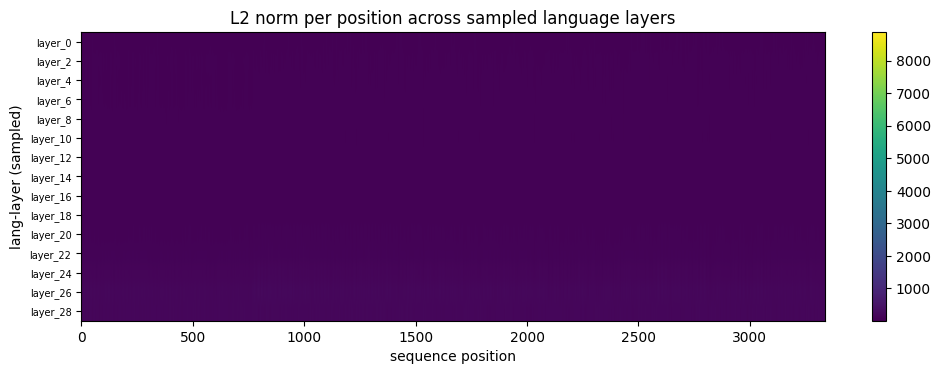

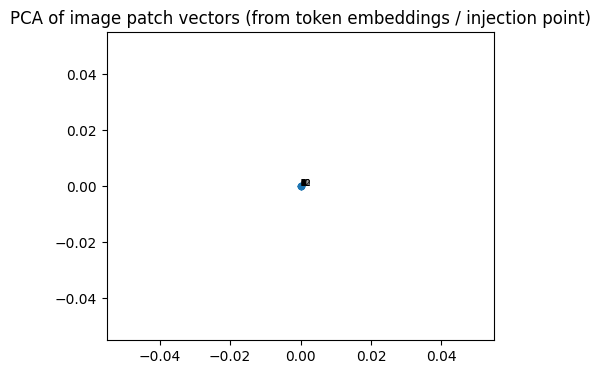

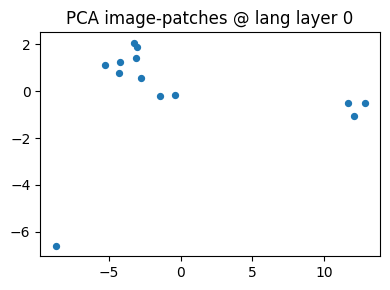

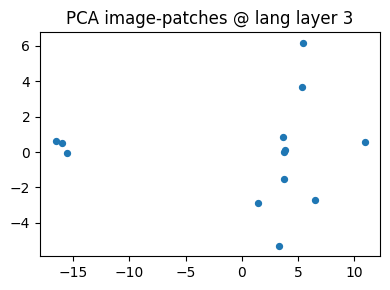

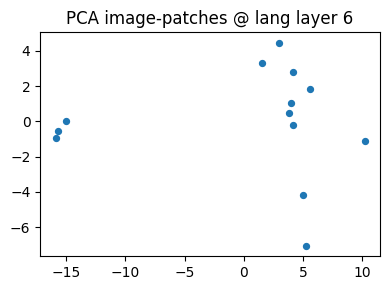

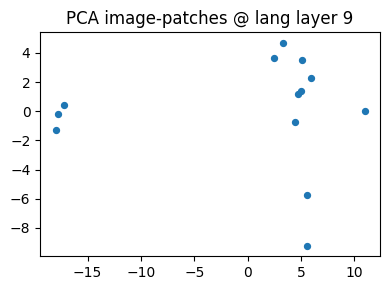

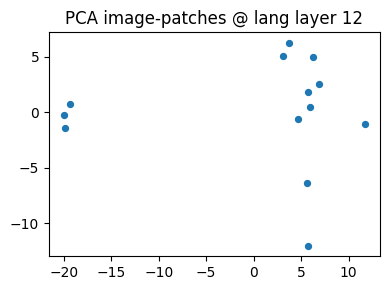

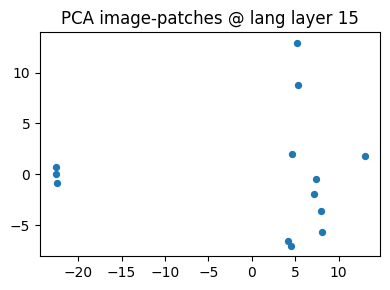

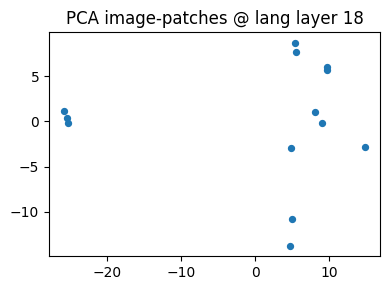

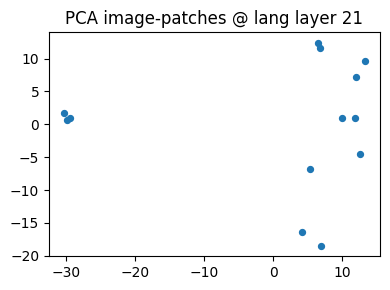

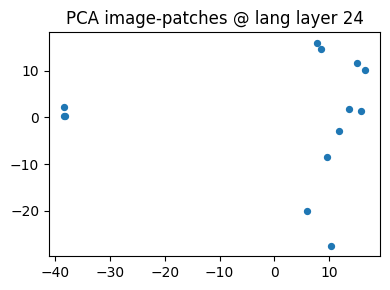

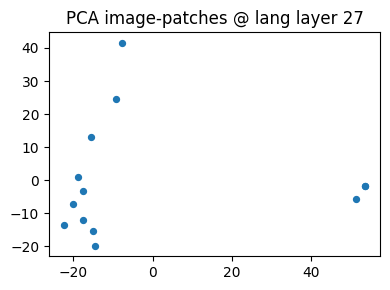

In [23]:
out = inspect_hidden_states(image_path=dir, model=model, tokenizer= tokenizer, prompt="<image> Give me the title of this document.")

In [24]:
# Criar espaço de input para os vit_embeds
device = model.device
num_patches = pixel_values.shape[0]
image_tokens = '<img>' + ('<IMG_CONTEXT>' * model.num_image_token * num_patches) + '</img>'
question = "<image> Give me the title of this document."
question = question.replace('<image>', image_tokens, 1)

inputs = tokenizer(question, return_tensors='pt').to(device)

In [25]:
model.num_image_token * num_patches

3328

In [26]:
len(inputs['input_ids'][0])

3338

In [28]:
inputs['input_ids'][0][3335]

tensor(419, device='cuda:0')

In [29]:
# 1. Localize a camada de embeddings dentro do seu modelo
# (O caminho exato vem do seu print anterior: language_model -> model -> embed_tokens)
embedding_layer = model.language_model.model.embed_tokens

# 2. Acesse o vetor correspondente ao ID 419
# A propriedade .weight contém a matriz inteira [vocab_size, hidden_size]
token_id = 419
static_vector = embedding_layer.weight[token_id]

print(f"Token: {tokenizer.convert_ids_to_tokens(token_id)}")
print(f"Shape do vetor: {static_vector.shape}")
print(f"Primeiros valores: {static_vector}")

Token: Ġthis
Shape do vetor: torch.Size([1536])
Primeiros valores: tensor([ 0.0054, -0.0140, -0.0111,  ..., -0.0386,  0.0254,  0.0128],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<SelectBackward0>)


In [30]:
embedding_layer = model.language_model.model.embed_tokens
embedding_layer.weight.shape

torch.Size([151674, 1536])

In [31]:
inputs['input_ids']

tensor([[151665, 151667, 151667,  ...,    419,   2197,     13]],
       device='cuda:0')

In [32]:
out['lang_hidden_states'][-1][0]

tensor([[ 2.6094, -1.4922, -3.3125,  ...,  1.2188, -0.3223,  1.8359],
        [-2.4219, -1.8125,  2.5469,  ..., -1.6719, -3.0000,  3.6094],
        [-2.9375, -3.7812,  3.1250,  ..., -4.8750, -1.2891, -0.0471],
        ...,
        [-1.1406, -1.7969,  4.3438,  ...,  1.4531, -0.0884,  2.0625],
        [-0.7812, -0.4863,  1.5000,  ...,  1.8359, -2.5625, -0.8047],
        [-1.0312, -0.4102,  4.2188,  ...,  2.2500, -1.0078,  0.2559]],
       device='cuda:0', dtype=torch.bfloat16)

In [33]:
import pandas as pd
import torch

# Seus inputs
ids = inputs['input_ids'][0]  # Remove a dimensão do batch, fica com (seq_len,)
# Vamos pegar a ÚLTIMA camada como exemplo de embedding contextualizado
# Mas você pode trocar por [0] para ver o embedding estático de entrada
layer_idx = -1 
vectors = out['lang_hidden_states'][layer_idx][0] # Shape (seq_len, hidden_dim)

data = []

# Itera sobre cada posição da sequência
for i, token_id_tensor in enumerate(ids):
    token_id = token_id_tensor.item()
    
    # 1. Recuperar o texto do token
    # convert_ids_to_tokens é melhor que decode aqui para ver tokens especiais
    token_str = tokenizer.convert_ids_to_tokens(token_id)
    
    # Caso o tokenizer retorne bytes ou algo estranho (comum no Qwen/InternVL), tratamos:
    if isinstance(token_str, bytes):
        token_str = token_str.decode('utf-8', errors='replace')
    
    # 2. Pegar o embedding correspondente
    vec = vectors[i]
    
    # Vamos guardar algumas métricas do vetor para não imprimir o vetor inteiro de 4096 dimensoes
    vec_norm = vec.float().norm().item()
    vec_sample = vec.tolist() # Primeiros 5 valores para inspeção visual
    
    data.append({
        "Pos": i,
        "ID": token_id,
        "Token": token_str,
        "Norma (L2)": vec_norm,
        "Amostra Vetor": [round(x, 4) for x in vec_sample]
    })

# Criar DataFrame para visualização limpa
df = pd.DataFrame(data)

# Configurar pandas para mostrar tudo
pd.set_option('display.max_rows', 20) 
pd.set_option('display.max_colwidth', None)

# print(f"Analisando Embeddings da camada {layer_idx} (Total tokens: {len(df)})")
# print(df.head(10)) # Mostra o início (tokens especiais de imagem)
# print("...")
# print(df.tail(10)) # Mostra o fim (tokens de texto e EOS)

In [34]:
df[3320:]

,Pos,ID,Token,Norma (L2),Amostra Vetor
3320,3320,151667,<IMG_CONTEXT>,158.134323,"[-1.7188, -2.5781, 1.8516, -4.0938, 2.2031, -0.3906, -0.625, 2.0312, -1.875, -3.5781, 1.5078, 0.2148, 2.3281, -0.4004, -4.8438, -3.875, 1.1953, -1.0781, -2.9219, -1.5859, 2.0312, 2.25, -3.4375, 1.4062, 2.6719, 0.0322, -3.4688, -2.4375, 4.0, -1.4609, 3.3906, 2.7812, 2.5469, 2.125, 0.8398, 2.0781, 0.6133, 1.3672, 1.5859, 6.6562, 0.291, -1.3359, -1.6016, -1.7812, -1.1562, 4.25, -5.5312, 4.5625, -2.5938, 0.3203, 0.6562, 0.1396, -0.9688, 4.4688, -0.957, -5.1875, 1.6797, 1.5078, 2.3906, -1.6484, -1.1562, 5.0625, 1.9922, -1.7188, -0.2656, -2.25, 1.1953, -1.1094, 1.2344, -0.6094, -2.8281, -0.0244, 2.5625, 1.1406, -1.9219, -2.4688, -2.9531, 2.875, -0.8945, -2.0469, -0.793, 1.2344, -2.2031, -14.4375, 0.7969, -0.9648, 6.0938, -1.875, 5.9062, -4.2188, -0.2471, -0.9023, -0.064, -1.6953, 2.3438, 3.0469, -1.6719, -3.5, 4.1875, -3.0781, ...]"
3321,3321,151667,<IMG_CONTEXT>,151.987579,"[-3.3594, 1.3984, -0.0903, -0.8242, 2.6875, -0.0654, -1.0, 2.3438, -2.4844, -0.3496, 0.083, -6.5312, -0.6836, -3.6406, -2.0938, -5.7812, 1.8828, -3.1094, -2.3594, 3.4688, 0.8164, 1.0938, -0.052, 1.75, -0.4434, -2.7344, -3.125, 2.625, -0.2793, -3.5469, 0.8203, -0.252, -0.0674, 2.625, -1.0234, 0.0703, -0.1338, -0.2598, 0.4141, -0.1177, -0.2539, 1.0625, -0.498, 0.4238, 0.8828, -1.4453, 6.1875, -0.5742, 0.6523, -0.4629, -1.2656, 1.3516, 0.209, 2.0938, -0.9766, 0.8516, -0.5625, -1.2031, 2.9219, -2.8281, 1.375, 2.4219, 3.8906, -0.4766, 0.6094, -1.0156, -0.6953, -0.7422, 3.0625, -2.4219, 0.0291, 1.5469, 2.7969, 3.8438, 1.5469, -1.8359, -1.9375, 0.9375, -0.1621, -1.7344, 0.2598, 2.3594, -2.375, -16.0, 0.9609, -2.2656, 1.3906, -1.125, 2.1406, -2.5, 2.5938, -1.6719, 1.9531, 3.0156, 2.125, 3.1406, 0.3711, -0.21, -4.5312, -2.2188, ...]"
3322,3322,151667,<IMG_CONTEXT>,160.420227,"[-2.625, -1.5781, 2.5156, -2.4219, 3.0156, -1.8672, -0.8594, 2.2812, -2.7188, -1.5234, 1.1016, -1.4844, 0.3984, -2.3125, -2.375, -2.7344, 0.6055, -2.3125, -1.6328, -0.2188, 0.2988, 1.4922, -0.7695, 2.7188, 2.9531, 0.2832, -1.5156, 2.625, 4.0312, -1.0938, 3.2188, -1.3203, 2.0781, 2.2031, -1.25, 0.5273, 0.5, -0.2656, -1.3516, 4.2188, 1.8906, -0.4238, -1.5781, -0.2832, -1.25, 0.1182, -1.6797, 1.7969, 0.5117, 0.2656, -0.2139, -1.5625, -1.1094, 4.8438, 0.5234, -2.5469, 0.6328, -0.9648, 1.5781, -4.1562, 1.8359, 2.2656, 2.6094, -0.2383, 1.2344, 1.9453, -0.3691, -0.9336, 1.4766, -1.6875, 0.4395, 0.7617, 0.1787, 0.0308, 0.3223, -3.0781, -1.2891, 0.4297, 0.957, -0.5977, 2.3281, 1.2812, -1.2969, -21.5, 0.7188, -2.8125, 2.9062, -0.9414, 3.4844, -2.5, 2.0938, 1.1406, -0.2188, 1.5312, 3.1562, 1.375, 0.063, -1.7109, -1.2344, -1.2734, ...]"
3323,3323,151667,<IMG_CONTEXT>,125.568657,"[-2.0469, 1.3281, 3.5938, -0.1338, 1.8906, -2.7969, -0.0049, 1.7656, -1.1328, 0.9141, -2.7969, -3.25, 1.0078, -1.125, 0.8359, -5.1875, 1.5, -2.1875, -3.0312, 2.6406, 1.1094, 1.2734, -1.3047, 2.6719, 1.1875, 1.0391, -4.0938, 1.5078, 1.625, -0.6016, -0.2373, 1.1016, 1.4141, -0.8203, -0.8789, 0.8594, 0.3652, -1.0625, -0.8555, -1.8281, -1.4922, -0.4844, -1.375, 2.6406, 0.2344, -1.3594, 0.9883, -2.0938, -0.5898, 2.4844, 0.6758, 2.2188, -2.5156, 3.5156, 0.0776, 2.2656, 3.2969, -2.1875, 1.2812, -3.2344, 0.7695, 2.5938, 1.375, 1.2812, 1.1328, 0.3262, 2.0625, 3.2969, 0.498, -2.6562, -1.9531, -2.8438, 0.6914, 0.4121, 1.4609, -1.1797, -0.5742, -0.0199, 0.7227, 2.6719, 1.7344, 0.8086, -2.3281, -15.3125, 0.4082, -3.5469, 2.6875, -1.8359, 2.0, -1.9375, 2.4531, 1.3672, 1.6641, 3.4219, 0.6523, 4.6875, 1.1328, 1.8984, -1.5703, -2.5469, ...]"
3324,3324,151667,<IMG_CONTEXT>,144.866089,"[-0.0559, -0.6172, 1.8047, -2.6094, 2.3594, -4.0625, 1.4766, 2.25, -4.6562, -3.1562, -1.0156, -3.0, 2.7812, 1.25, -2.4844, -2.9531, 0.167, 0.6602, -3.1562, 1.3125, 1.6094, 3.7812, -0.1484, 1.3984, 1.5938, 1.4141, -4.7188, 1.5938, 3.7969, 1.3828, 2.0781, 3.7969, 0.6914, 2.0625, -3.0312, 1.8516, 0.0815, 3.5625, 0.1416, 6.1562, -0.0603, -0.1699, -3.3594, -1.9922, 0.207, 2.25, -3.2031, 1.5, -0.197

In [35]:
import torch

# Assumindo que out['lang_hidden_states'] é o objeto
states = out['lang_hidden_states']

print(f"Tipo do objeto: {type(states)}")
print(f"Quantidade de camadas (tensors): {len(states)}")

# Verifica o shape do primeiro (embeddings) e do último (camada 28)
# Shape padrão: (batch_size, sequence_length, hidden_size)
if len(states) > 0:
    print(f"Shape Embeddings (idx 0): {states[0].shape}")
    print(f"Shape Última Camada (idx -1): {states[-1].shape}")

Tipo do objeto: <class 'tuple'>
Quantidade de camadas (tensors): 29
Shape Embeddings (idx 0): torch.Size([1, 3338, 1536])
Shape Última Camada (idx -1): torch.Size([1, 3338, 1536])


In [213]:
model

InternVLChatModel(
  (vision_model): InternVisionModel(
    (embeddings): InternVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): InternVisionEncoder(
      (layers): ModuleList(
        (0): InternVisionEncoderLayer(
          (attn): InternAttention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (inner_attn): FlashAttention()
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (mlp): InternMLP(
            (act): GELUActivation()
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affin

In [36]:
import torch.nn.functional as F
import matplotlib.pyplot as plt # Opcional, para plotar se estiver num notebook

similarities = []
norms = []

print("\n--- Análise Camada a Camada ---")
print(f"{'Camada':<10} | {'Média L2 Norm':<15} | {'Simil. Cosseno (vs anterior)':<30}")

for i, layer_tensor in enumerate(states):
    # layer_tensor shape: (batch, seq_len, hidden_dim)
    
    # 1. Calcular a Norma L2 média (magnitude do sinal)
    # Convertemos para float32 para evitar overflow se estiver em fp16/bf16
    layer_norm = layer_tensor.float().norm(p=2, dim=-1).mean().item()
    norms.append(layer_norm)
    
    cos_sim_val = 0.0
    if i > 0:
        # Compara a camada atual (i) com a anterior (i-1)
        prev_tensor = states[i-1].float()
        curr_tensor = layer_tensor.float()
        
        # Cosseno ao longo da dimensão oculta (hidden_dim)
        # Resultado shape: (batch, seq_len) -> tiramos a média
        sim = F.cosine_similarity(prev_tensor, curr_tensor, dim=-1)
        cos_sim_val = sim.mean().item()
        similarities.append(cos_sim_val)
        
        print(f"{i:<10} | {layer_norm:<15.4f} | {cos_sim_val:<30.6f}")
    else:
        print(f"{i:<10} | {layer_norm:<15.4f} | {'-':<30}")

# Dica: Se a similaridade cosseno ficar muito próxima de 1.0 (ex: 0.99) nas últimas camadas,
# significa que o modelo já convergiu e camadas adicionais estão fazendo pouco trabalho.


--- Análise Camada a Camada ---
Camada     | Média L2 Norm   | Simil. Cosseno (vs anterior)  
0          | 29.9481         | -                             
1          | 40.4629         | 0.806584                      
2          | 42.0469         | 0.913501                      
3          | 43.3238         | 0.897976                      
4          | 44.0371         | 0.902463                      
5          | 46.7978         | 0.904381                      
6          | 44.4393         | 0.918721                      
7          | 45.1331         | 0.915507                      
8          | 46.2171         | 0.899784                      
9          | 45.4632         | 0.920667                      
10         | 45.6923         | 0.924569                      
11         | 46.5192         | 0.925751                      
12         | 48.9274         | 0.920332                      
13         | 51.3602         | 0.924595                      
14         | 53.9993         | 0.9331

In [37]:
import torch
import torch.nn.functional as F

# states: lista de tensores, cada um shape (batch, seq_len, hidden_dim)
# (usa exatamente a mesma variável `states` do seu código)

mean_norms = []
mean_similarities = []
mean_distances = []

print("\n--- Análise Mean-Pooling Camada a Camada ---")
print(f"{'Camada':<10} | {'Média L2 Norm (mean-pool)':<25} | {'Simil. Cosseno (vs anterior)':<30} | {'Distância (1 - cos)'}")

for i, layer_tensor in enumerate(states):
    # layer_tensor: (batch, seq_len, hidden_dim)
    t = layer_tensor.float()  # evita problemas com fp16/bf16

    # mean-pooling ao longo da dimensão seq_len -> (batch, hidden_dim)
    pooled = t.mean(dim=1)  # mean over seq_len

    # 1) Norma L2 média (sobre batch)
    pooled_norm_mean = pooled.norm(p=2, dim=-1).mean().item()
    mean_norms.append(pooled_norm_mean)

    if i > 0:
        prev_pooled = states[i-1].float().mean(dim=1)

        # cosine_similarity por exemplo no batch, dim=-1 -> (batch,)
        sim_batch = F.cosine_similarity(prev_pooled, pooled, dim=-1)
        sim_mean = sim_batch.mean().item()
        mean_similarities.append(sim_mean)

        # distância de cosseno (1 - sim)
        dist_mean = (1.0 - sim_batch).mean().item()
        mean_distances.append(dist_mean)

        print(f"{i:<10} | {pooled_norm_mean:<25.4f} | {sim_mean:<30.6f} | {dist_mean:.6f}")
    else:
        print(f"{i:<10} | {pooled_norm_mean:<25.4f} | {'-':<30} | {'-':>10}")

# Opcional: se quiser armazenar arrays para plot
# mean_norms, mean_similarities, mean_distances


--- Análise Mean-Pooling Camada a Camada ---
Camada     | Média L2 Norm (mean-pool) | Simil. Cosseno (vs anterior)   | Distância (1 - cos)
0          | 17.7725                   | -                              |          -
1          | 23.3591                   | 0.780079                       | 0.219921
2          | 23.8396                   | 0.897922                       | 0.102078
3          | 22.5371                   | 0.910449                       | 0.089551
4          | 23.6271                   | 0.906460                       | 0.093540
5          | 25.8087                   | 0.948038                       | 0.051962
6          | 25.2209                   | 0.953551                       | 0.046449
7          | 25.9132                   | 0.961014                       | 0.038986
8          | 25.7749                   | 0.927421                       | 0.072579
9          | 24.3656                   | 0.970147                       | 0.029853
10         | 22.8939        

In [139]:
print("\n--- Checagem de Valores Extremos ---")
print(f"{'Camada':<10} | {'Min Value':<12} | {'Max Value':<12} | {'Std Dev':<12}")

for i, layer_tensor in enumerate(states):
    t_float = layer_tensor.float()
    print(f"{i:<10} | {t_float.min().item():<12.4f} | {t_float.max().item():<12.4f} | {t_float.std().item():<12.4f}")


--- Checagem de Valores Extremos ---
Camada     | Min Value    | Max Value    | Std Dev     
0          | -10.5625     | 8.5000       | 0.7960      
1          | -13.9375     | 11.3750      | 1.0678      
2          | -2016.0000   | 1600.0000    | 1.8167      
3          | -5056.0000   | 3984.0000    | 3.8630      
4          | -5184.0000   | 4080.0000    | 3.9558      
5          | -5248.0000   | 4128.0000    | 4.0205      
6          | -5344.0000   | 4192.0000    | 4.0657      
7          | -5344.0000   | 4192.0000    | 4.0701      
8          | -5344.0000   | 4192.0000    | 4.0770      
9          | -5344.0000   | 4192.0000    | 4.0716      
10         | -5344.0000   | 4192.0000    | 4.0730      
11         | -5344.0000   | 4192.0000    | 4.0780      
12         | -5344.0000   | 4192.0000    | 4.0949      
13         | -5344.0000   | 4192.0000    | 4.1129      
14         | -5344.0000   | 4192.0000    | 4.1340      
15         | -5344.0000   | 4192.0000    | 4.1209      
16        

In [38]:
# Vision encoder layers
print("Vision encoder layers:")
for i, layer in enumerate(model.vision_model.encoder.layers):
    print(f"vision_layer[{i}] -> {layer.__class__.__name__}")

# Language (decoder) layers
lm = model.language_model.model
print("\nLanguage decoder layers:")
for i, layer in enumerate(lm.layers):
    print(f"decoder_layer[{i}] -> {layer.__class__.__name__}")

Vision encoder layers:
vision_layer[0] -> InternVisionEncoderLayer
vision_layer[1] -> InternVisionEncoderLayer
vision_layer[2] -> InternVisionEncoderLayer
vision_layer[3] -> InternVisionEncoderLayer
vision_layer[4] -> InternVisionEncoderLayer
vision_layer[5] -> InternVisionEncoderLayer
vision_layer[6] -> InternVisionEncoderLayer
vision_layer[7] -> InternVisionEncoderLayer
vision_layer[8] -> InternVisionEncoderLayer
vision_layer[9] -> InternVisionEncoderLayer
vision_layer[10] -> InternVisionEncoderLayer
vision_layer[11] -> InternVisionEncoderLayer
vision_layer[12] -> InternVisionEncoderLayer
vision_layer[13] -> InternVisionEncoderLayer
vision_layer[14] -> InternVisionEncoderLayer
vision_layer[15] -> InternVisionEncoderLayer
vision_layer[16] -> InternVisionEncoderLayer
vision_layer[17] -> InternVisionEncoderLayer
vision_layer[18] -> InternVisionEncoderLayer
vision_layer[19] -> InternVisionEncoderLayer
vision_layer[20] -> InternVisionEncoderLayer
vision_layer[21] -> InternVisionEncoderLay

In [39]:
def param_summary(mod):
    total = 0
    trainable = 0
    for p in mod.parameters():
        total += p.numel()
        if p.requires_grad:
            trainable += p.numel()
    return total, trainable

print("Submodule | total_params | trainable_params")
for name, sub in model.named_children():
    t, tr = param_summary(sub)
    print(f"{name:20s} | {t:12d} | {tr:12d}")


Submodule | total_params | trainable_params
vision_model         |    304012288 |    304012288
language_model       |   1776283136 |   1776283136
mlp1                 |      8662016 |      8662016


In [40]:
def get_submodule(root, path):  # path = "language_model.model.layers.27.self_attn.q_proj"
    cur = root
    for p in path.split('.'):
        cur = getattr(cur, p)
    return cur

In [41]:
def print_trainable_status(root):
    for name, p in root.named_parameters():
        print(f"{name:70s} | {'TRAINABLE' if p.requires_grad else 'frozen'}")

# ex:
print_trainable_status(model.language_model.model)

embed_tokens.weight                                                    | TRAINABLE
layers.0.self_attn.q_proj.weight                                       | TRAINABLE
layers.0.self_attn.q_proj.bias                                         | TRAINABLE
layers.0.self_attn.k_proj.weight                                       | TRAINABLE
layers.0.self_attn.k_proj.bias                                         | TRAINABLE
layers.0.self_attn.v_proj.weight                                       | TRAINABLE
layers.0.self_attn.v_proj.bias                                         | TRAINABLE
layers.0.self_attn.o_proj.weight                                       | TRAINABLE
layers.0.mlp.gate_proj.weight                                          | TRAINABLE
layers.0.mlp.up_proj.weight                                            | TRAINABLE
layers.0.mlp.down_proj.weight                                          | TRAINABLE
layers.0.input_layernorm.weight                                        | TRAINABLE
laye

In [47]:
# siamese_wrapper.py
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Callable, Optional

# ----------------------
# Pooling e Proj Head
# ----------------------
class AttnPool(nn.Module):
    """Pooling aprendível sobre tokens: learnable query -> softmax -> weighted sum."""
    def __init__(self, dim: int):
        super().__init__()
        self.q = nn.Parameter(torch.randn(dim) * 0.02)  # small init
        self.proj = nn.Identity()  # opcional, pode ser Linear(dim, dim)

    def forward(self, tokens: torch.Tensor, mask: Optional[torch.Tensor] = None):
        # tokens: (B, N, D), mask optional: (B, N) True=valid
        scores = torch.einsum('d,bnd->bn', self.q, tokens)  # (B,N)
        if mask is not None:
            scores = scores.masked_fill(~mask.bool(), float('-inf'))
        weights = torch.softmax(scores, dim=-1)  # (B,N)
        pooled = torch.einsum('bn,bnd->bd', weights, tokens)  # (B,D)
        return self.proj(pooled)


class ProjHead(nn.Module):
    """Projection head: LayerNorm -> FC -> Act -> FC -> L2 normalize."""
    def __init__(self, in_dim: int, hidden_dim: int = 1024, out_dim: int = 256):
        super().__init__()
        self.ln = nn.LayerNorm(in_dim)
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x: torch.Tensor):
        x = self.ln(x)
        x = self.act(self.fc1(x))
        x = self.fc2(x)
        x = F.normalize(x, dim=-1)
        return x


# ----------------------
# Wrapper Siamesa
# ----------------------
class SiameseInternVL(nn.Module):
    """
    Wrapper que cria uma cabeça siamesa a partir do InternVLChatModel.

    - model: o InternVLChatModel carregado (com vision_model, mlp1, language_model)
    - cut_layer: índice da layer cujas hidden_states serão usadas (ex.: 27)
    - encode_fn: Optional[Callable], função externa que recebe (model, images, device, cut_layer)
                 e retorna tokens (B, seq_len, hidden_dim) correspondentes ao output
                 APÓS a camada cut_layer (ou no ponto que você desejar). Se None,
                 tentamos usar model.language_model.model(..., output_hidden_states=True).
    """
    def __init__(self,
                 model,
                 cut_layer: int = 27,
                 pool_dim: int = 1536,
                 proj_hidden: int = 1024,
                 proj_out: int = 256,
                 encode_fn: Optional[Callable] = None):
        super().__init__()
        self.backbone = model
        self.cut_layer = cut_layer
        self.pool = AttnPool(pool_dim)
        self.head = ProjHead(pool_dim, hidden_dim=proj_hidden, out_dim=proj_out)
        self.encode_fn = encode_fn  # user-provided pipeline to get tokens at cut point

        # by default freeze everything; user can unfreeze selected params later
        self.freeze_all_backbone()

    # ---------- parameter control ----------
    def freeze_all_backbone(self):
        for p in self.backbone.parameters():
            p.requires_grad = False

    def unfreeze_params_by_names(self, param_name_list):
        """Recebe lista de nomes parciais; define requires_grad=True para parâmetros correspondentes."""
        for name, p in self.backbone.named_parameters():
            for pat in param_name_list:
                if pat in name:
                    p.requires_grad = True
                    break

    def set_default_trainable(self):
        """
        Configuração sugerida: torna treináveis exatamente os parâmetros que você enunciou:
            layers.27.self_attn.* q_proj,k_proj,v_proj,o_proj
            layers.27.mlp.* gate_proj,up_proj,down_proj
            layers.27.input_layernorm / post_attention_layernorm
            norm.weight
        Adapta para o namespace do HF model: language_model.model.layers.<i>...
        """
        # freeze all first
        self.freeze_all_backbone()
        # We'll look for substrings to match the params you listed
        keys = [
            f"language_model.model.layers.{self.cut_layer}.self_attn.q_proj",
            f"language_model.model.layers.{self.cut_layer}.self_attn.k_proj",
            f"language_model.model.layers.{self.cut_layer}.self_attn.v_proj",
            f"language_model.model.layers.{self.cut_layer}.self_attn.o_proj",
            f"language_model.model.layers.{self.cut_layer}.mlp.gate_proj",
            f"language_model.model.layers.{self.cut_layer}.mlp.up_proj",
            f"language_model.model.layers.{self.cut_layer}.mlp.down_proj",
            f"language_model.model.layers.{self.cut_layer}.input_layernorm",
            f"language_model.model.layers.{self.cut_layer}.post_attention_layernorm",
            f"language_model.model.norm",  # top-level norm
        ]
        # Unfreeze matching params
        self.unfreeze_params_by_names(keys)

    def trainable_parameters(self):
        return [ (n,p) for n,p in self.named_parameters() if p.requires_grad ]

    # ---------- forward helpers ----------
    def _extract_tokens_via_encode_fn(self, images, device=None, **encode_kwargs):
        """
        If user provided encode_fn, call it: encode_fn(backbone, images, cut_layer, **kwargs).
        Must return tokens: (B, seq_len, hidden_dim) and optional mask (B, seq_len).
        """
        assert callable(self.encode_fn), "encode_fn não fornecida; não é possível usar esta rota."
        out = self.encode_fn(self.backbone, images, cut_layer=self.cut_layer, **encode_kwargs)
        # expected: either tensor tokens or tuple(tokens, mask)
        if isinstance(out, tuple):
            tokens, mask = out
        else:
            tokens, mask = out, None
        return tokens, mask

    def _extract_tokens_via_hidden_states(self, input_ids=None, attention_mask=None, device=None, **kwargs):
        """
        Extrai hidden_states da layer self.cut_layer (antes do norm e antes do lm_head).
        Norm final e lm_head foram substituídos por nn.Identity() no modelo.
        """
        lm = self.backbone.language_model.model

        call_args = dict(output_hidden_states=True, return_dict=True)
        if input_ids is not None:
            call_args["input_ids"] = input_ids.to(device)
        if attention_mask is not None:
            call_args["attention_mask"] = attention_mask.to(device)
        call_args.update(kwargs)

        out = lm(**call_args)
        hidden_states = out.hidden_states

        # hidden_states[0] = embeddings
        # hidden_states[1] = saída após layer 0
        # ...
        # hidden_states[self.cut_layer+1] = saída após layer 27
        idx = self.cut_layer + 1

        tokens = hidden_states[idx]   # (B, seq_len, D)
        return tokens, None


    # ---------- main forward ----------
    def forward(self, images=None, input_ids=None, attention_mask=None, device=None, encode_kwargs=None):
        """
        Returns normalized embeddings z (B, out_dim).
        - If encode_fn provided: use it with `images` to extract tokens at cut point.
        - Else: try using LM forward with input_ids and output_hidden_states to get tokens.
        """
        device = device or (next(self.parameters()).device)
        if self.encode_fn is not None:
            tokens, mask = self._extract_tokens_via_encode_fn(images, device=device, **(encode_kwargs or {}))
        else:
            tokens, mask = self._extract_tokens_via_hidden_states(input_ids=input_ids,
                                                                 attention_mask=attention_mask,
                                                                 device=device,
                                                                 **(encode_kwargs or {}))

        # tokens: (B, seq_len, D)
        out = self.pool(tokens, mask=mask)  # (B, D)
        z = self.head(out)  # (B, out_dim), already normalized
        return z


In [48]:
# Remover lm_head
model.language_model.lm_head = nn.Identity()

# Remover norm final
lm = model.language_model.model
lm.norm = nn.Identity()

In [49]:
# ----------------------
# Helper: create siamese object and print trainable params
# ----------------------
def create_siamese_from_internvl(model, cut_layer=27, encode_fn: Optional[Callable] = None,
                                 pool_dim=1536, proj_hidden=1024, proj_out=256,
                                 set_trainable_by_default=True):
    """
    Factory function: builds SiameseInternVL wrapper around `model`.
    If set_trainable_by_default True, it will unfreeze the params you listed previously.
    """
    siam = SiameseInternVL(model, cut_layer=cut_layer, pool_dim=pool_dim,
                          proj_hidden=proj_hidden, proj_out=proj_out, encode_fn=encode_fn)
    if set_trainable_by_default:
        siam.set_default_trainable()
    # Print trainable param summary
    total = 0
    trainable = 0
    print("\nTrainable parameters in the siamese wrapper:")
    for name, p in siam.named_parameters():
        n = p.numel()
        total += n
        if p.requires_grad:
            trainable += n
            print(f"  {name:70s} | TRAINABLE | shape={tuple(p.shape)}")
    print(f"Total params: {total:,} | Trainable: {trainable:,} ({100.0 * trainable/total:.2f}%)")
    return siam

In [ ]:
# backbone = seu InternVLChatModel já carregado
# encode_fn = sua função (recomendada) que devolve tokens (B,N,D) no ponto cut_layer
siam = build_siamese_internvl(backbone=backbone, cut_layer=27, encode_fn=encode_fn,
                             pool_dim=1536, proj_hidden=1024, proj_out=256, set_trainable=True)

# conferir parâmetros que serão treinados
siam.trainable_summary()

# gerar embeddings (B, out_dim)
# imgs tensor shape (B,C,H,W) — encode_fn será usada
# z = siam(images=imgs)



Trainable parameters in the siamese wrapper:
  backbone.language_model.model.layers.27.self_attn.q_proj.weight        | TRAINABLE | shape=(1536, 1536)
  backbone.language_model.model.layers.27.self_attn.q_proj.bias          | TRAINABLE | shape=(1536,)
  backbone.language_model.model.layers.27.self_attn.k_proj.weight        | TRAINABLE | shape=(256, 1536)
  backbone.language_model.model.layers.27.self_attn.k_proj.bias          | TRAINABLE | shape=(256,)
  backbone.language_model.model.layers.27.self_attn.v_proj.weight        | TRAINABLE | shape=(256, 1536)
  backbone.language_model.model.layers.27.self_attn.v_proj.bias          | TRAINABLE | shape=(256,)
  backbone.language_model.model.layers.27.self_attn.o_proj.weight        | TRAINABLE | shape=(1536, 1536)
  backbone.language_model.model.layers.27.mlp.gate_proj.weight           | TRAINABLE | shape=(8960, 1536)
  backbone.language_model.model.layers.27.mlp.up_proj.weight             | TRAINABLE | shape=(8960, 1536)
  backbone.language

In [51]:
siam

SiameseInternVL(
  (backbone): InternVLChatModel(
    (vision_model): InternVisionModel(
      (embeddings): InternVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
      )
      (encoder): InternVisionEncoder(
        (layers): ModuleList(
          (0): InternVisionEncoderLayer(
            (attn): InternAttention(
              (qkv): Linear(in_features=1024, out_features=3072, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (inner_attn): FlashAttention()
              (proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (mlp): InternMLP(
              (act): GELUActivation()
              (fc1): Linear(in_features=1024, out_features=4096, bias=True)
              (fc2): Linear(in_features=4096, out_features=1024, bias=True)
            )
            (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=T